In [2]:
!pip install opencv-python scikit-image numpy matplotlib


  Using cached scikit_image-0.25.2-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl (12.9 MB)
Using cached scikit_image-0.25.2-cp311-cp311-win_amd64.whl (12.8 MB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 1.26.4

   ---------------------------------------- 0/6 [numpy]
    Uninstalling numpy-1.26.4:
   ---------------------------------------- 0/6 [numpy]
   ---------------------------------------- 0/6 [numpy]
   ---------------------------------------- 0/6 [numpy]
   ---------------------------------------- 0/6 [numpy]
   ---------------------------------------- 0/6 [numpy]
   --------------------------------------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
tensorflow-intel 2.16.1 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.5.3 which is incompatible.
tensorflow-intel 2.16.1 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 2.2.6 which is incompatible.


In [3]:
!pip install scikit-image

In [107]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [3]:
def calculate_angle(a, b, c):
    ba = (a[0]-b[0], a[1]-b[1])
    bc = (c[0]-b[0], c[1]-b[1])
    dot_product = ba[0]*bc[0] + ba[1]*bc[1]
    mag_ba = math.sqrt(ba[0]**2 + ba[1]**2)
    mag_bc = math.sqrt(bc[0]**2 + bc[1]**2)
    cosine_angle = dot_product / (mag_ba * mag_bc + 1e-6)
    return math.degrees(math.acos(max(min(cosine_angle, 1), -1)))

def calculate_distance(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def extract_features_from_landmarks(landmarks):
    left_shoulder_angle = calculate_angle(landmarks[13], landmarks[11], landmarks[23])
    right_shoulder_angle = calculate_angle(landmarks[14], landmarks[12], landmarks[24])
    left_elbow_angle = calculate_angle(landmarks[11], landmarks[13], landmarks[15])
    right_elbow_angle = calculate_angle(landmarks[12], landmarks[14], landmarks[16])
    left_hip_angle = calculate_angle(landmarks[11], landmarks[23], landmarks[25])
    right_hip_angle = calculate_angle(landmarks[12], landmarks[24], landmarks[26])
    left_knee_angle = calculate_angle(landmarks[23], landmarks[25], landmarks[27])
    right_knee_angle = calculate_angle(landmarks[24], landmarks[26], landmarks[28])

    shoulder_distance = calculate_distance(landmarks[11], landmarks[12])
    hip_distance = calculate_distance(landmarks[23], landmarks[24])
    l_shoulder_to_hip = calculate_distance(landmarks[11], landmarks[23])
    r_shoulder_to_hip = calculate_distance(landmarks[12], landmarks[24])
    l_shoulder_to_ankle = calculate_distance(landmarks[11], landmarks[27])
    r_shoulder_to_ankle = calculate_distance(landmarks[12], landmarks[28])

    return [
        left_shoulder_angle, right_shoulder_angle,
        left_elbow_angle, right_elbow_angle,
        left_hip_angle, right_hip_angle,
        left_knee_angle, right_knee_angle,
        shoulder_distance, hip_distance,
        l_shoulder_to_hip, r_shoulder_to_hip,
        l_shoulder_to_ankle, r_shoulder_to_ankle
    ]

### LOAD DATASET

In [6]:
df = pd.read_csv("yoga_expanded_dataset.csv")  

X= df.drop(columns=["label"]).values
y = df["label"].values

In [7]:
print("Dataset shape:", X.shape)
print("Classes:", np.unique(y))

Dataset shape: (4430, 14)
Classes: ['Downdog' 'Goddess' 'Plank' 'Side Plank' 'Tree' 'Warrior']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved.")

Scaler saved.


In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

print("\n===== RANDOM FOREST =====")
print("Accuracy:", rf_acc)
print(classification_report(y_test, rf_pred))


===== RANDOM FOREST =====
Accuracy: 0.9841986455981941
              precision    recall  f1-score   support

     Downdog       1.00      1.00      1.00       186
     Goddess       1.00      0.97      0.98       129
       Plank       0.99      0.96      0.97       100
  Side Plank       0.96      0.95      0.95        95
        Tree       0.99      0.99      0.99       140
     Warrior       0.97      1.00      0.99       236

    accuracy                           0.98       886
   macro avg       0.98      0.98      0.98       886
weighted avg       0.98      0.98      0.98       886



In [13]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_scaled, y_train)

svm_pred = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, svm_pred)

print("\n===== SVM =====")
print("Accuracy:", svm_acc)
print(classification_report(y_test, svm_pred))


===== SVM =====
Accuracy: 0.9830699774266366
              precision    recall  f1-score   support

     Downdog       1.00      1.00      1.00       186
     Goddess       1.00      0.95      0.97       129
       Plank       0.99      0.97      0.98       100
  Side Plank       0.98      0.97      0.97        95
        Tree       0.98      0.99      0.98       140
     Warrior       0.96      1.00      0.98       236

    accuracy                           0.98       886
   macro avg       0.99      0.98      0.98       886
weighted avg       0.98      0.98      0.98       886



In [18]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    verbose=True
)
mlp.fit(X_train_scaled, y_train)

mlp_pred = mlp.predict(X_test_scaled)
mlp_acc = accuracy_score(y_test, mlp_pred)

print("\n===== MLP (Sklearn) =====")
print("Accuracy:", mlp_acc)
print(classification_report(y_test, mlp_pred))


Iteration 1, loss = 1.16255524
Iteration 2, loss = 0.53514143
Iteration 3, loss = 0.34751993
Iteration 4, loss = 0.27162012
Iteration 5, loss = 0.22232941
Iteration 6, loss = 0.18713148
Iteration 7, loss = 0.15716194
Iteration 8, loss = 0.13543326
Iteration 9, loss = 0.11731619
Iteration 10, loss = 0.10227611
Iteration 11, loss = 0.09044553
Iteration 12, loss = 0.08013066
Iteration 13, loss = 0.07258251
Iteration 14, loss = 0.06580074
Iteration 15, loss = 0.05835947
Iteration 16, loss = 0.05418491
Iteration 17, loss = 0.05153759
Iteration 18, loss = 0.04632828
Iteration 19, loss = 0.04202745
Iteration 20, loss = 0.03965556
Iteration 21, loss = 0.03710239
Iteration 22, loss = 0.03552643
Iteration 23, loss = 0.03368491
Iteration 24, loss = 0.03242625
Iteration 25, loss = 0.02973626
Iteration 26, loss = 0.02949320
Iteration 27, loss = 0.02764464
Iteration 28, loss = 0.02605204
Iteration 29, loss = 0.02509430
Iteration 30, loss = 0.02428056
Iteration 31, loss = 0.02370289
Iteration 32, los

In [19]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    verbose=False
)

# 5-Fold Stratified Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(mlp, X_train_scaled, y_train, cv=skf, scoring='accuracy')

print("\n===== Cross-Validation Results (MLP) =====")
print("Fold Accuracies:", scores)
print("Mean Accuracy:", scores.mean())
print("Std Deviation:", scores.std())


===== Cross-Validation Results (MLP) =====
Fold Accuracies: [0.9887165  0.9887165  0.98730606 0.98589563 0.98305085]
Mean Accuracy: 0.9867371088427245
Std Deviation: 0.002119260250013675


In [ ]:
import sys
import tensorflow as tf

print(sys.executable)
print(tf.__version__)


e:\project\Yoga_pose_estimation_cv\.venv\Scripts\python.exe
2.16.1


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [87]:

HEATMAP_DIR = r"dataset/heatmaps"


In [88]:
import os
import shutil
import random

SOURCE_DIR = r"dataset/heatmaps"
TRAIN_DIR = r"dataset/heatmaps/train"
VAL_DIR = r"dataset/heatmaps/val"

labels = os.listdir(SOURCE_DIR)
labels = [l for l in labels if os.path.isdir(os.path.join(SOURCE_DIR, l))]

split_ratio = 0.8 

for label in labels:
    os.makedirs(os.path.join(TRAIN_DIR, label), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, label), exist_ok=True)

    images = os.listdir(os.path.join(SOURCE_DIR, label))
    random.shuffle(images)

    split_point = int(len(images) * split_ratio)
    train_imgs = images[:split_point]
    val_imgs = images[split_point:]

    for img in train_imgs:
        shutil.copy(
            os.path.join(SOURCE_DIR, label, img),
            os.path.join(TRAIN_DIR, label, img)
        )

    for img in val_imgs:
        shutil.copy(
            os.path.join(SOURCE_DIR, label, img),
            os.path.join(VAL_DIR, label, img)
        )

print(" Train/Val Split Completed!")


 Train/Val Split Completed!


In [89]:
# IMAGE LOADING 

IMG_SIZE = 256
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.20,
    shear_range=0.15,
    horizontal_flip= True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)
train_gen = train_datagen.flow_from_directory(r"dataset/heatmaps/train",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=16,
    shuffle=True
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)
val_gen = val_datagen.flow_from_directory(
    r"dataset/heatmaps/val",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=16,
    shuffle=False
)

Found 333 images belonging to 6 classes.


Found 86 images belonging to 6 classes.


In [90]:
# CNN MODEL

IMAGE_SIZE = (224, 224)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same',
           input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D(2),
    Dropout(0.2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2),
    Dropout(0.3),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2),
    Dropout(0.4),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


e:\project\Yoga_pose_estimation_cv\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,158 (98.36 MB)

 Trainable params: 25,785,158 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_heatmap_model.keras",
    monitor="val_accuracy",
    save_best_only=True
)

# TRAIN THE MODEL
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30
    ,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.7327 - loss: 0.7836 - val_accuracy: 0.8256 - val_loss: 0.4428
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.7598 - loss: 0.6963 - val_accuracy: 0.8140 - val_loss: 0.4340
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.7057 - loss: 0.8142 - val_accuracy: 0.8372 - val_loss: 0.4307
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 603ms/step - accuracy: 0.7207 - loss: 0.7742 - val_accuracy: 0.8256 - val_loss: 0.4384
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step - accuracy: 0.7447 - loss: 0.7163 - val_accuracy: 0.8372 - val_loss: 0.4138
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.7327 - loss: 0.7459 - val_accuracy: 0.8372 - val_loss: 0.4175
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.7477 - loss: 0.6861 - val_accuracy: 0.8372 - val_loss: 0.3895
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step - accuracy: 0.7778 - loss: 0.7378 - val_accuracy: 0

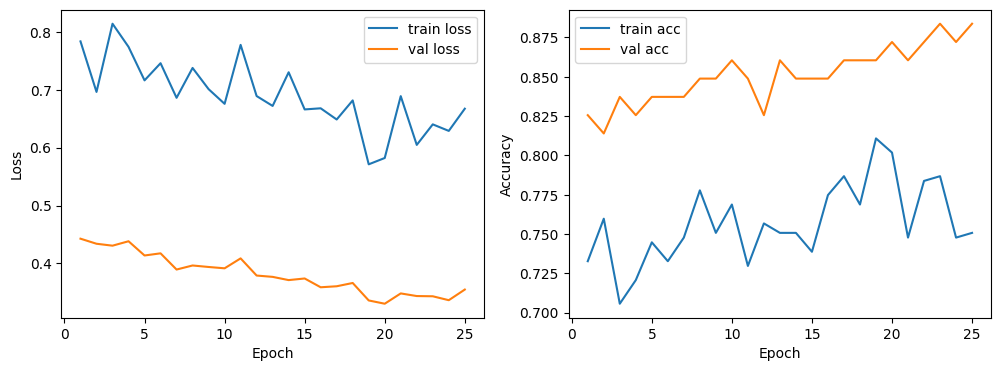

In [94]:
import matplotlib.pyplot as plt

# `history` is the returned History from model.fit
def plot_history(history):
    h = history.history
    epochs = range(1, len(h['loss'])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train loss')
    plt.plot(epochs, h['val_loss'], label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend();

    plt.subplot(1,2,2)
    plt.plot(epochs, h['accuracy'], label='train acc')
    plt.plot(epochs, h['val_accuracy'], label='val acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend();

    plt.show()

plot_history(history)

### CNN(EfficientNETB0)

In [58]:
pip install tensorflow keras tensorflow-addons


  Using cached ml_dtypes-0.3.2-cp311-cp311-win_amd64.whl.metadata (20 kB)
Using cached ml_dtypes-0.3.2-cp311-cp311-win_amd64.whl (127 kB)
   ---------------------------------------- 0.0/719.8 kB ? eta -:--:--
   -------------- ------------------------- 262.1/719.8 kB ? eta -:--:--
   ---------------------------------------- 719.8/719.8 kB 7.3 MB/s  0:00:00

  Attempting uninstall: ml-dtypes

    Found existing installation: ml_dtypes 0.5.3

    Uninstalling ml_dtypes-0.5.3:

      Successfully uninstalled ml_dtypes-0.5.3

   ------------- -------------------------- 1/3 [ml-dtypes]
   ------------- -------------------------- 1/3 [ml-dtypes]
   ------------- -------------------------- 1/3 [ml-dtypes]
   ------------- -------------------------- 1/3 [ml-dtypes]
   ------------- -------------------------- 1/3 [ml-dtypes]
   ------------- -------------------------- 1/3 [ml-dtypes]
   ------------- -------------------------- 1/3 [ml-dtypes]
   ------------- -------------------------- 1/3 [ml-

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.1 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.
jaxlib 0.7.1 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.


In [108]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight


DATA_DIR = r"dataset/heatmaps"  
TRAIN_DIR = os.path.join(DATA_DIR, r"train")
VAL_DIR   = os.path.join(DATA_DIR, r"val")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS_HEAD = 15                
EPOCHS_FINE = 15 # ---------- Check dataset ----------
def count_files(path):
    data = {}
    for cls in sorted(os.listdir(path)):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            data[cls] = len([f for f in os.listdir(cls_path)
                             if f.lower().endswith(('.jpg','.jpeg','.png'))])
    return data

train_counts = count_files(TRAIN_DIR)
val_counts   = count_files(VAL_DIR)

print("Train counts:", train_counts)
print("Val   counts:", val_counts)

# ---------- Compute class weights ----------
classes = sorted(train_counts.keys())
y_temp = []
for idx, cls in enumerate(classes):
    y_temp += [idx] * train_counts[cls]

if len(y_temp) > 0:
    class_weights = compute_class_weight('balanced', classes=np.arange(len(classes)), y=np.array(y_temp))
    class_weights = dict(enumerate(class_weights))
    print("Class Weights:", class_weights)
else:
    class_weights = None

# ------------ Data Augmentation ------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

# LOAD DATASET

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    color_mode="rgb",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    validation_split=0.2,
    subset="validation",
    color_mode="rgb",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

#  Extract class names BEFORE prefetching
class_names = train_ds.class_names
num_classes = len(class_names)
print("Detected Classes:", class_names)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)



base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
   
)

base_model.trainable = False   # step 1: freeze model

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)                             # apply augmentation
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)

outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()
# STEP 1 — TRAIN CLASSIFIER HEAD
print("\n===== TRAINING TOP CLASSIFIER LAYERS =====")
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD
)
# STEP 2 — UNFREEZE AND FINE-TUNE
print("\n===== FINE-TUNING THE FULL MODEL =====")
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

# very small LR to avoid destroying pretrained weights
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINE
)




Train counts: {'Downdog': 69, 'Goddess': 58, 'Plank': 56, 'Side Plank': 20, 'Tree': 51, 'Warrior': 79}
Val   counts: {'Downdog': 18, 'Goddess': 15, 'Plank': 14, 'Side Plank': 6, 'Tree': 13, 'Warrior': 20}
Class Weights: {0: 0.8043478260869565, 1: 0.9568965517241379, 2: 0.9910714285714286, 3: 2.775, 4: 1.088235294117647, 5: 0.7025316455696202}
Found 333 files belonging to 6 classes.
Using 267 files for training.
Found 86 files belonging to 6 classes.
Using 17 files for validation.
Detected Classes: ['Downdog', 'Goddess', 'Plank', 'Side Plank', 'Tree', 'Warrior']


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_24 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,049 (16.70 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


===== TRAINING TOP CLASSIFIER LAYERS =====
Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 494ms/step - accuracy: 0.5581 - loss: 1.2643 - val_accuracy: 0.8824 - val_loss: 0.5415
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.8464 - loss: 0.5879 - val_accuracy: 1.0000 - val_loss: 0.2755
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.8427 - loss: 0.4677 - val_accuracy: 1.0000 - val_loss: 0.1412
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.8839 - loss: 0.3382 - val_accuracy: 1.0000 - val_loss: 0.0965
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9139 - loss: 0.2954 - val_accuracy: 1.0000 - val_loss: 0.0647
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.9363 - loss: 0.2239 - val_accuracy: 1.0000 - val_loss: 0.0731
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9101 - loss: 0.2553 - val_accuracy: 1.0000 - val_loss: 0.0846
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accur

In [110]:
train_count = 0
val_count = 0

for imgs, labels in train_ds:
    train_count += len(imgs)

for imgs, labels in val_ds:
    val_count += len(imgs)

print("Train samples:", train_count)
print("Validation samples:", val_count)


Train samples: 267
Validation samples: 17


### USE CNN FEATURES + RF/MLP 

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

HEATMAP_DIR = r"dataset/heatmaps/train"   # your heatmap dataset folder
IMG_SIZE = 224             # EfficientNet required size


from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

feature_extractor = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

print(" Loaded EfficientNetB0 feature extractor")

def extract_features(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    feat = feature_extractor.predict(img, verbose=0)
    return feat.flatten()

# BUILD FEATURE DATASET
X = []
y = []

print(" Extracting CNN features from heatmaps...")

for label in os.listdir(HEATMAP_DIR):
    class_dir = os.path.join(HEATMAP_DIR, label)
    if not os.path.isdir(class_dir):
        continue

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print("Skipping corrupt:", img_path)
            continue

        feat = extract_features(img)
        X.append(feat)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("✔ Feature extraction complete")
print("Feature shape:", X.shape)
print("Labels:", set(y))


# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


 Loaded EfficientNetB0 feature extractor
 Extracting CNN features from heatmaps...


In [3]:
print("\n=== Training Random Forest ===")
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    random_state=42
)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
print("\n--- Random Forest Results ---")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))



=== Training Random Forest ===


NameError: name 'RandomForestClassifier' is not defined

In [106]:
print("\n=== Training MLP (Sklearn) ===")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),
    activation="relu",
    solver="adam",
    max_iter=300,
    random_state=42
)
mlp_model.fit(X_train, y_train)

mlp_pred = mlp_model.predict(X_test)
print("\n--- MLP Results ---")
print("Accuracy:", accuracy_score(y_test, mlp_pred))
print(classification_report(y_test, mlp_pred))

print(" All models trained successfully!")


=== Training MLP (Sklearn) ===

--- MLP Results ---
Accuracy: 0.9850746268656716
              precision    recall  f1-score   support

     Downdog       1.00      1.00      1.00        14
     Goddess       1.00      1.00      1.00        12
       Plank       0.92      1.00      0.96        11
  Side Plank       1.00      0.75      0.86         4
        Tree       1.00      1.00      1.00        10
     Warrior       1.00      1.00      1.00        16

    accuracy                           0.99        67
   macro avg       0.99      0.96      0.97        67
weighted avg       0.99      0.99      0.98        67

 All models trained successfully!


In [113]:
import pickle
with open("mlp_model.pkl", "wb") as f:
    pickle.dump(mlp_model, f)

print("MLP model saved as mlp_model.pkl")

MLP model saved as mlp_model.pkl


In [ ]:
from sklearn.preprocessing import LabelEncoder
import json
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Save class names for real-time inference
with open("class_names.json", "w") as f:
    json.dump(list(le.classes_), f)

print("✔ Saved class_names.json:", le.classes_)


NameError: name 'y_train' is not defined